In [1]:
#Data Loading and Data Cleaning
import pandas as pd
import re

# Load the dataset
chegg_df = pd.read_csv("Summative_Assignment_6/Chegg.csv", encoding="ISO-8859-1")

# Remove duplicate tweets
chegg_df.drop_duplicates(subset="text", inplace=True)

# Remove irrelevant columns
chegg_df.drop(columns=["timestamp_epochs", "tweet_url", "links", "has_media", "img_urls", "video_url", "parent_tweet_id", "reply_to_users"], inplace=True)

# Replace NaN values with an empty string
chegg_df["text"].fillna("", inplace=True)

# Remove retweets
chegg_df = chegg_df[~chegg_df["text"].str.startswith("RT")]

# Define a function to clean the tweet text
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove mentions
    text = re.sub(r"@\w+", "", text)
    # Remove special characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = " ".join(text.split())
    return text

# Clean the tweet text
chegg_df["text"] = chegg_df["text"].apply(clean_text)

# Print the cleaned dataset
chegg_df.head()

,screen_name,username,user_id,tweet_id,timestamp,text,text_html,hashtags,likes,retweets,replies,is_replied,is_reply_to
0,NewsFromSPI,SPI News,3.932026e+08,1.045100e+18,26/09/18 23:53,bragar eagel and squire pc is investigating ch...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],1,0,0,False,False
1,feed_stocks,Stocks News Feed - Stock News & Stocks Chat,1.006330e+18,1.045100e+18,26/09/18 23:53,bragar eagel amp squire pc is investigating ch...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],0,0,0,False,False
2,corey_mossberg,Corey M,9.928670e+17,1.045100e+18,26/09/18 23:52,chegg was down around today after news of the ...,"<p class=""TweetTextSize js-tweet-text tweet-te...","['madtweets', 'madmoney']",0,0,0,False,False
3,HomeboyHarry_,YourFavoriteUncle,1.446320e+08,1.045100e+18,26/09/18 23:51,fuck chegg stopped working im tryna get this h...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],1,0,0,False,False
4,Ashlynskye__,Ash_Ù_Ü,4.254011e+08,1.045100e+18,26/09/18 23:48,who got a chegg account i could use,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],0,0,0,False,False


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tsang\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


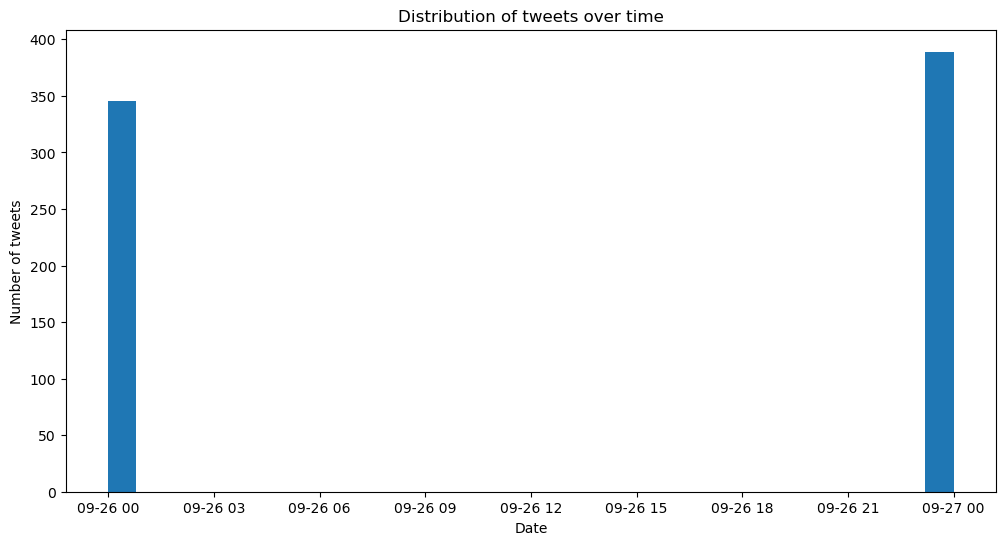

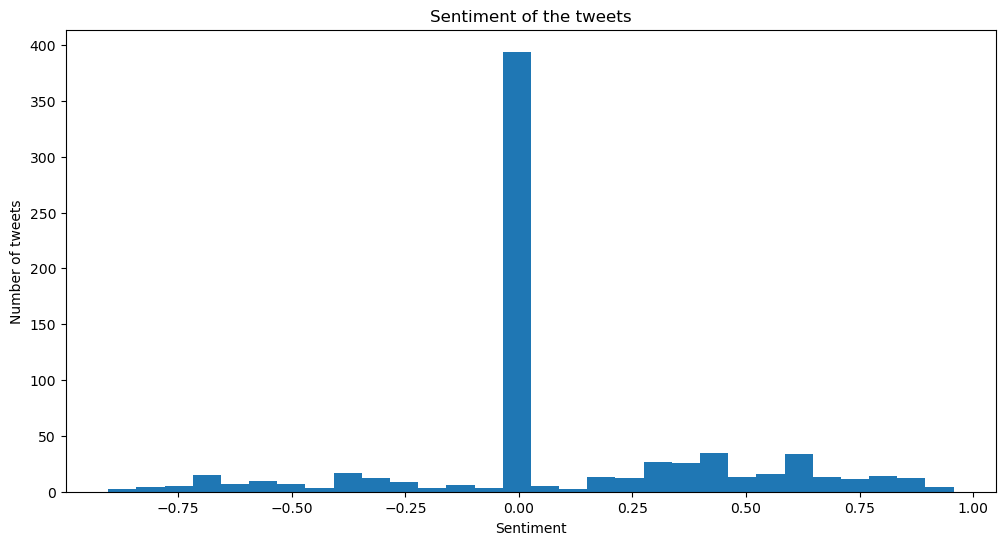

In [2]:
#Data Exploration

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
%matplotlib inline

# Perform sentiment analysis using NLTK
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()
chegg_df["Sentiment"] = chegg_df["text"].apply(lambda x: sia.polarity_scores(x)["compound"])

# Plot the distribution of tweets over time
plt.figure(figsize=(12, 6))
plt.hist(pd.to_datetime(chegg_df["timestamp"], format="%d/%m/%y %H:%M").dt.date, bins=30)
plt.xlabel("Date")
plt.ylabel("Number of tweets")
plt.title("Distribution of tweets over time")
plt.show()

# Plot the sentiment of the tweets
plt.figure(figsize=(12, 6))
plt.hist(chegg_df["Sentiment"], bins=30)
plt.xlabel("Sentiment")
plt.ylabel("Number of tweets")
plt.title("Sentiment of the tweets")
plt.show()

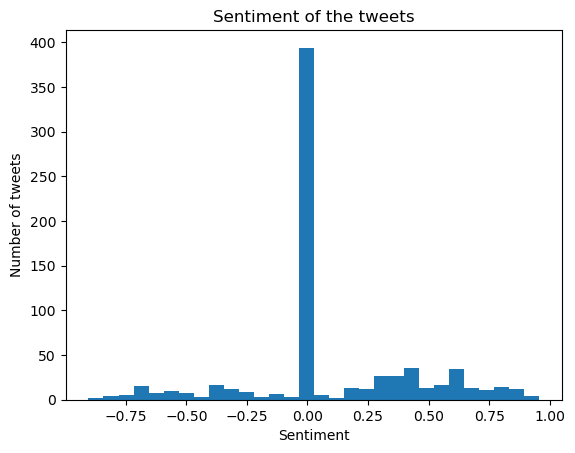

In [3]:
#Dealing with the high 0 Sentiment Score

# Load additional data into the dataframe
chegg_df2 = pd.read_csv("Summative_Assignment_6/Chegg.csv", encoding="ISO-8859-1")
# Convert float values in "text" column to strings
chegg_df["text"] = chegg_df["text"].astype(str)

# Perform sentiment analysis on the tweets
chegg_df["Sentiment"] = chegg_df["text"].apply(lambda x: sia.polarity_scores(x)["compound"])

# Plot a histogram of the sentiment scores
plt.hist(chegg_df["Sentiment"], bins=30)
plt.xlabel("Sentiment")
plt.ylabel("Number of tweets")
plt.title("Sentiment of the tweets")
plt.show()

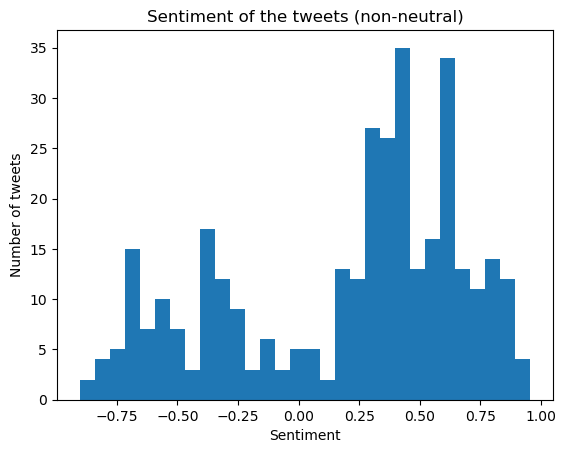

In [4]:
#Dealing with the high 0 Sentiment Score #5
#The result remains, so here is going to remove tweets with a sentiment score of 0
chegg_df = chegg_df[chegg_df["Sentiment"] != 0]

# Plot a histogram of the non-neutral sentiment scores
plt.hist(chegg_df["Sentiment"], bins=30)
plt.xlabel("Sentiment")
plt.ylabel("Number of tweets")
plt.title("Sentiment of the tweets (non-neutral)")
plt.show()

In [5]:
#Feature Engineering

import re

# Define a function to count the number of hashtags in a tweet
def count_hashtags(tweet):
    return len(re.findall(r"#(\w+)", tweet))

# Define a function to count the number of mentions in a tweet
def count_mentions(tweet):
    return len(re.findall(r"@(\w+)", tweet))

# Create the features
# Sentiment Score
chegg_df["Sentiment"] = chegg_df["text"].apply(lambda x: sia.polarity_scores(x)["compound"])
# Number of works
chegg_df["NumWords"] = chegg_df["text"].apply(lambda x: len(x.split()))
# Number of hashtags
chegg_df["NumHashtags"] = chegg_df["text"].apply(lambda x: count_hashtags(x))
# Number of mentions
chegg_df["NumMentions"] = chegg_df["text"].apply(lambda x: count_mentions(x))

In [6]:
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

# Define the list of breached companies
breached_companies = ["Marriott", "Chegg", "UnderArmour", "T-mobile"]

# Define a function to check if a tweet mentions a breached company
def mentions_breached_company(tweet):
    for company in breached_companies:
        if company.lower() in tweet.lower():
            return 1
    return 0

# Create the "Breached" column
chegg_df["Breached"] = chegg_df["text"].apply(lambda x: mentions_breached_company(x))

# Add the "Sentiment" feature
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()
chegg_df["Sentiment"] = chegg_df["text"].apply(lambda x: sia.polarity_scores(x)["compound"])

# Add the "NumWords" feature
chegg_df["NumWords"] = chegg_df["text"].apply(lambda x: len(re.findall(r'\w+', x)))

# Add the "NumHashtags" feature
chegg_df["NumHashtags"] = chegg_df["text"].apply(lambda x: len(re.findall(r'#\w+', x)))

# Add the "NumMentions" feature
chegg_df["NumMentions"] = chegg_df["text"].apply(lambda x: len(re.findall(r'@\w+', x)))

# Add the "HashtagSentiment" feature
def get_hashtag_sentiment(hashtag):
    sia = SentimentIntensityAnalyzer()
    total_sentiment = 0
    num_words = 0
    for word in re.findall(r'\w+', hashtag):
        sentiment = sia.polarity_scores(word)["compound"]
        total_sentiment += sentiment
        num_words += 1
    if num_words > 0:
        return total_sentiment / num_words
    else:
        return 0

if "hashtags" in chegg_df.columns and not chegg_df["hashtags"].isnull().values.any():
    chegg_df["Hashtags"] = chegg_df["hashtags"].apply(lambda x: re.findall(r"#(\w+)", x))
    chegg_df["HashtagSentiment"] = chegg_df["Hashtags"].apply(lambda x: sum(get_hashtag_sentiment(hashtag) for hashtag in x) / len(x) if len(x) > 0 else 0)
else:
    chegg_df["Hashtags"] = ""
    chegg_df["HashtagSentiment"] = 0

# Define the features and target variable
X = chegg_df[["Sentiment", "NumWords", "NumHashtags", "NumMentions", "HashtagSentiment"]]
y = chegg_df["Breached"]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle class imbalance using oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_scaled, y)

# Define the models
models = [("LR", LogisticRegression(random_state=42)),
          ("SVM", SVC(random_state=42)),
          #("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
          #("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
          ("ANN", MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)),
          ("LR-Liblinear", LogisticRegression(solver='liblinear', random_state=42)),
          ("SVM-Linear", SVC(kernel='linear', C=1, random_state=42))#,
          #("K-means", KMeans(n_clusters=2, random_state=42))
          ]

results = pd.DataFrame(columns=["Model", "Accuracy", "ROC AUC", "Precision", "Recall", "F1-score", "MSE", "MAE"])

# Train and evaluate the models using cross-validation
for name, model in models:
    if X_resampled is not None and y_resampled is not None:
        y_pred = cross_val_predict(model, X_resampled, y_resampled, cv=10)
    else:
        y_pred = []
    accuracy = accuracy_score(y_resampled, y_pred)
    roc_auc = roc_auc_score(y_resampled, y_pred)
    precision = precision_score(y_resampled, y_pred)
    recall = recall_score(y_resampled, y_pred)
    f1 = f1_score(y_resampled, y_pred)
    mse = mean_squared_error(y_resampled, y_pred)
    mae = mean_absolute_error(y_resampled, y_pred)
    results = results.append({"Model": name, "Accuracy": accuracy, "ROC AUC": roc_auc, "Precision": precision, "Recall": recall, "F1-score": f1, "MSE": mse, "MAE": mae}, ignore_index=True)

# Print the results
results

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tsang\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Model,Accuracy,ROC AUC,Precision,Recall,F1-score,MSE,MAE
0,LR,0.543403,0.543403,0.549801,0.479167,0.512059,0.456597,0.456597
1,SVM,0.666667,0.666667,0.663265,0.677083,0.670103,0.333333,0.333333
2,ANN,0.807292,0.807292,0.839080,0.760417,0.797814,0.192708,0.192708
3,LR-Liblinear,0.543403,0.543403,0.549801,0.479167,0.512059,0.456597,0.456597
4,SVM-Linear,0.538194,0.538194,0.553922,0.392361,0.459350,0.461806,0.461806


In [7]:
#chegg_df.to_csv('check.csv')